# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [44]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [45]:
CONTEXT_WINDOW = 200 # words to display for context

Phrases to Track

In [46]:
SEARCH_PHRASES = {
    # Day
    "107 Day": r'\b107\s+days?(?:\'s?)?(?:-\w+)?\b',
    
    # Campaign
    "Campaign": r'\bcampaigns?(?:\'s?)?(?:-\w+)?\b',
    
    # Donald / Trump
    "Donald": r'\b(?:donald|trump)(?:\'s?)?(?:-\w+)?\b',
    
    # Governor
    "Governor": r'\bgovernors?(?:\'s?)?(?:-\w+)?\b',
    
    # Public Service
    "Public Service": r'\bpublic\s+services?(?:\'s?)?(?:-\w+)?\b',
    
    # 2028
    "2028": r'\b2028(?:\'s?)?(?:-\w+)?\b',
    
    # Unburdened
    "Unburdened": r'\bunburdened(?:\'s?)?(?:-\w+)?\b',
    
    # Debate
    "Debate": r'\bdebates?(?:\'s?)?(?:-\w+)?\b',
    
    # Recession
    "Recession": r'\brecessions?(?:\'s?)?(?:-\w+)?\b',
    
    # Retire
    "Retire": r'\bretires?(?:\'s?)?(?:-\w+)?\b',
    
    # Bipartisan
    "Bipartisan": r'\bbipartisan(?:\'s?)?(?:-\w+)?\b',
    
    # Nomination
    "Nomination": r'\bnominations?(?:\'s?)?(?:-\w+)?\b',
    
    # Big Ugly Bill
    "Big Ugly Bill": r'\bbig\s+ugly\s+bills?(?:\'s?)?(?:-\w+)?\b',
    
    # Constitutional crisis
    "Constitutional Crisis": r'\bconstitutional\s+crises(?:\'s?)?(?:-\w+)?\b',
    
    # Autopen
    "Autopen": r'\bautopens?(?:\'s?)?(?:-\w+)?\b',
    
    # Zohran / Mamdani
    "Zohran": r'\b(?:zohran|mamdani)(?:\'s?)?(?:-\w+)?\b',
    
    # Defeat
    "Defeat": r'\bdefeats?(?:\'s?)?(?:-\w+)?\b',
    
    # TikTok
    "TikTok": r'\btiktoks?(?:\'s?)?(?:-\w+)?\b',
    
    # Gavin / Newsom
    "Gavin": r'\b(?:gavin|newsom)(?:\'s?)?(?:-\w+)?\b',
    
    # Beyonce
    "Beyonce": r'\bbeyonces?(?:\'s?)?(?:-\w+)?\b',
    
    # Cognitive Decline
    "Cognitive Decline": r'\bcognitive\s+declines?(?:\'s?)?(?:-\w+)?\b',
    
    # Comrade
    "Comrade": r'\bcomrades?(?:\'s?)?(?:-\w+)?\b',
    
    # Cole / Ella / Emhoff
    "Cole": r'\b(?:cole|ella|emhoff)(?:\'s?)?(?:-\w+)?\b',
    
    # Elon / Musk
    "Elon": r'\b(?:elon|musk)(?:\'s?)?(?:-\w+)?\b',
    
    # DOGE / Department of Government Efficiency
    "DOGE": r'\b(?:doge|department\s+of\s+government\s+efficiency)(?:\'s?)?(?:-\w+)?\b',
    
    # Tariff
    "Tariff": r'\btariffs?(?:\'s?)?(?:-\w+)?\b',
    
    # Cancelled
    "Cancelled": r'\bcancelled(?:\'s?)?(?:-\w+)?\b',
    
    # Biden
    "Biden": r'\bbidens?(?:\'s?)?(?:-\w+)?\b',
}

In [47]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    
    return pd.DataFrame(results)


In [48]:

df = process_directory('.../data-harris/processed-transcripts')
df

Categories found in directory:


""


In [49]:
# Process transcripts
df = process_directory('../data-harris/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings
df = df[df['category'] != 'press briefing']

# Split data by date and category
interview_mask = df['category'] == 'interview'

# Create interview dataframes
df_interview = df[interview_mask]

# Create non-interview dataframes
df_non_interview = df[~interview_mask]


# Print dataset statistics
print("Dataset Statistics:")
print("Interviews:")
print(f"All: {len(df_interview)}")

print("\nWord Count Statistics:")
print("Interviews:")
print(f"Average length: {df_interview['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("Interviews:")
if len(df_interview) > 0:
    print(f"Range: {df_interview['date'].min().strftime('%Y-%m-%d')} to {df_interview['date'].max().strftime('%Y-%m-%d')}")
else:
    print("No interviews found")


Categories found in directory:
- convention
- debate
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- speech
- vlog
Dataset Statistics:
Interviews:
All: 52

Word Count Statistics:
Interviews:
Average length: 2443 words

Date Ranges:
Interviews:
Range: 2024-07-02 to 2024-11-05


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)

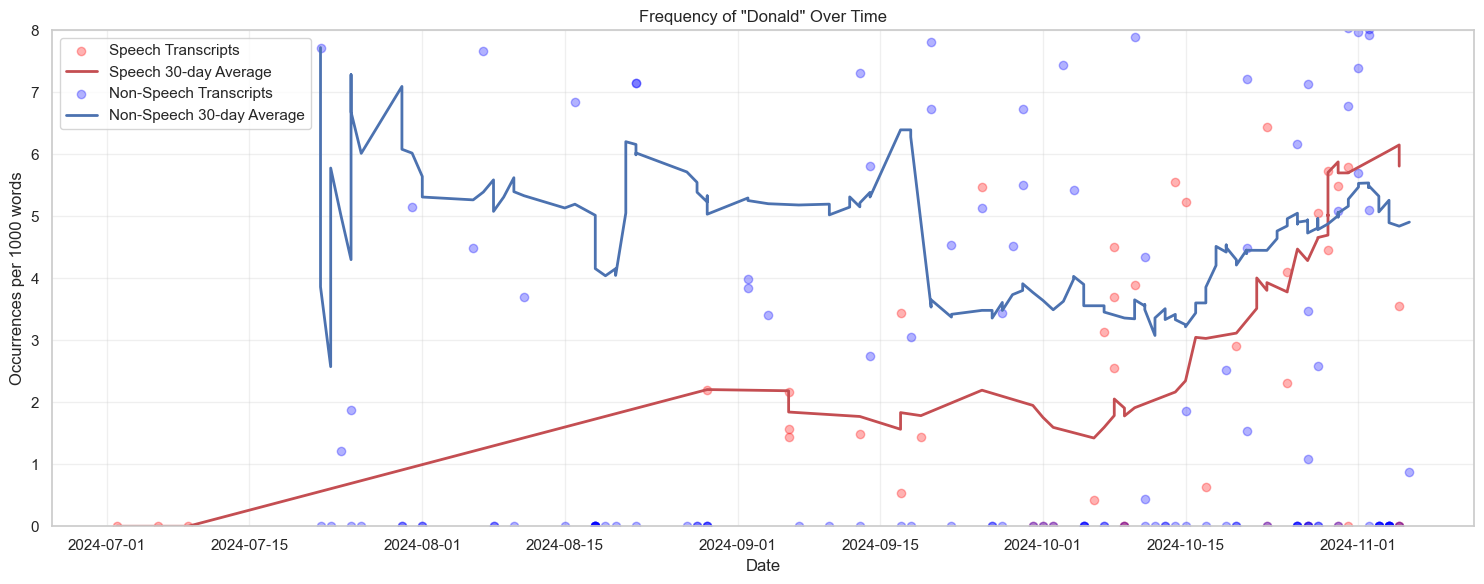

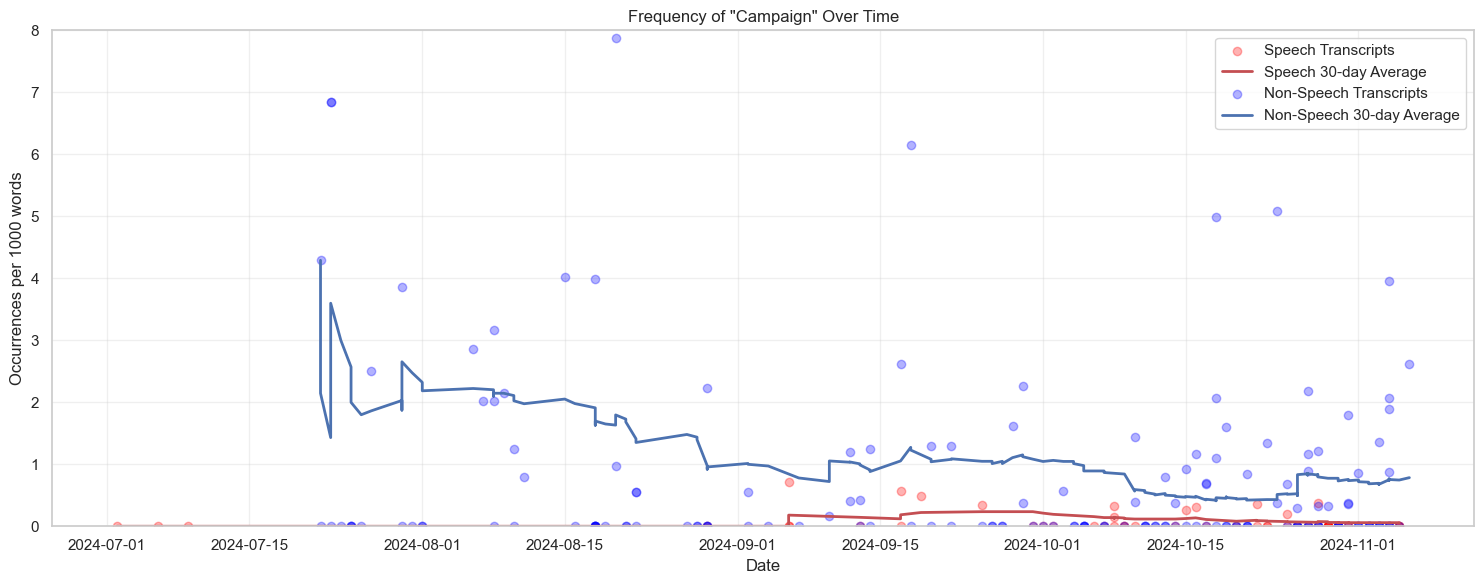

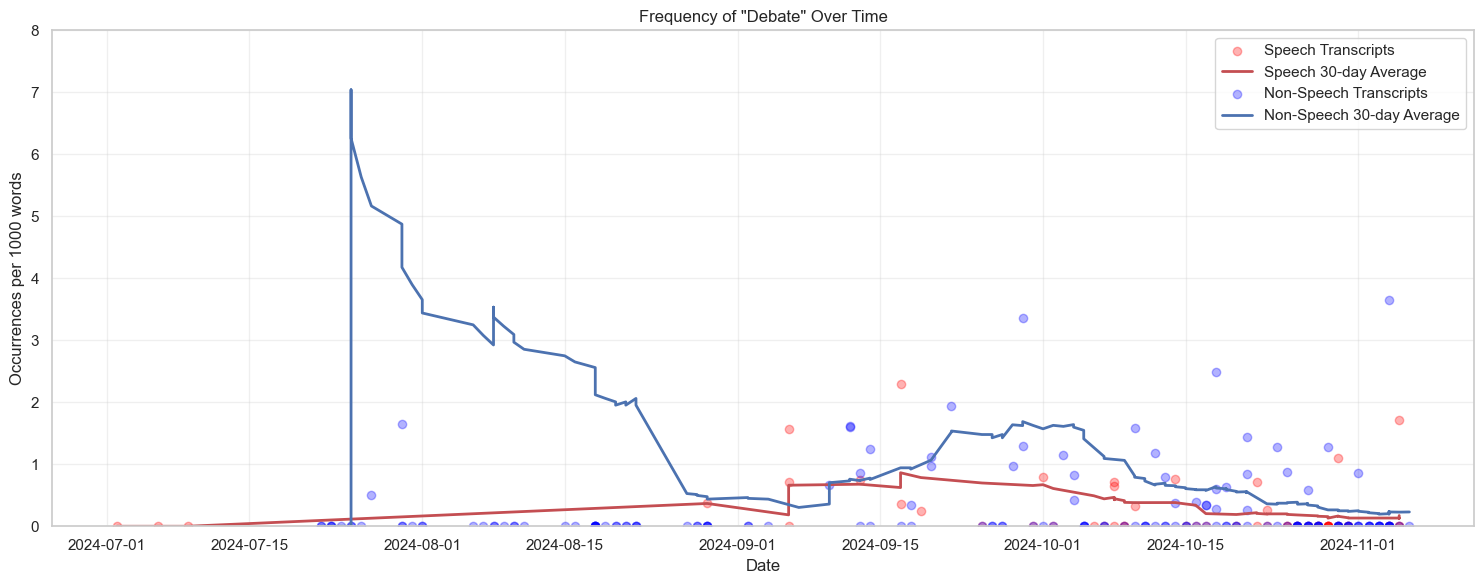

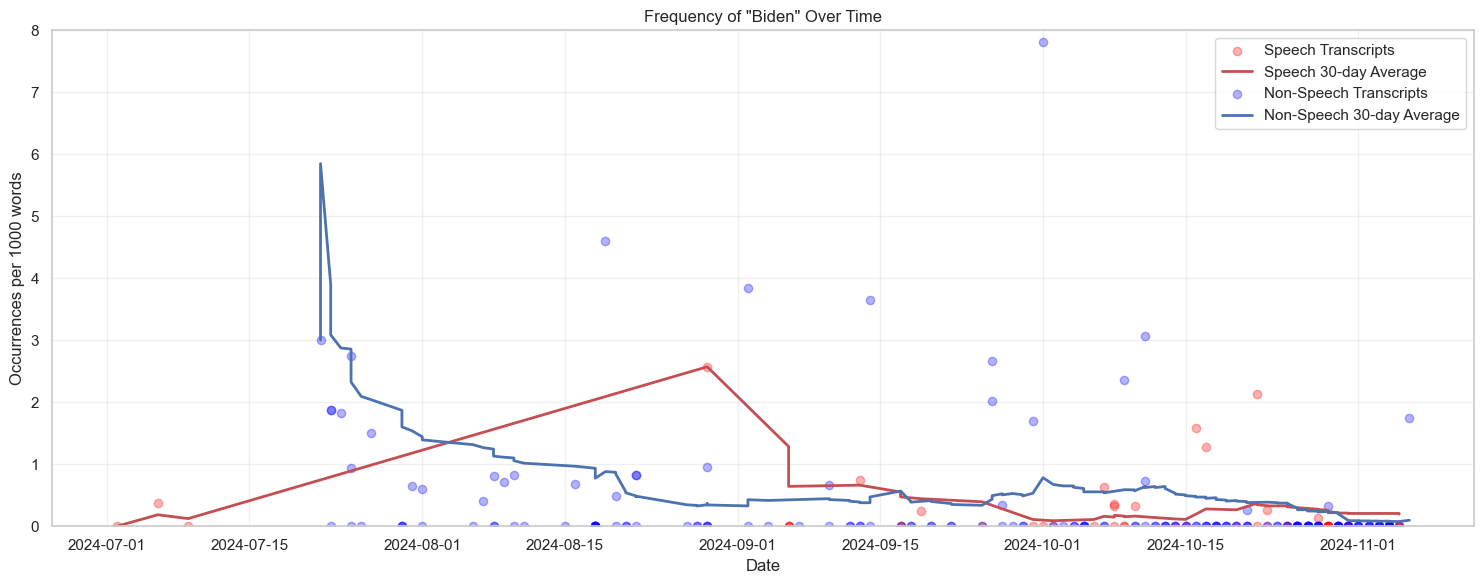

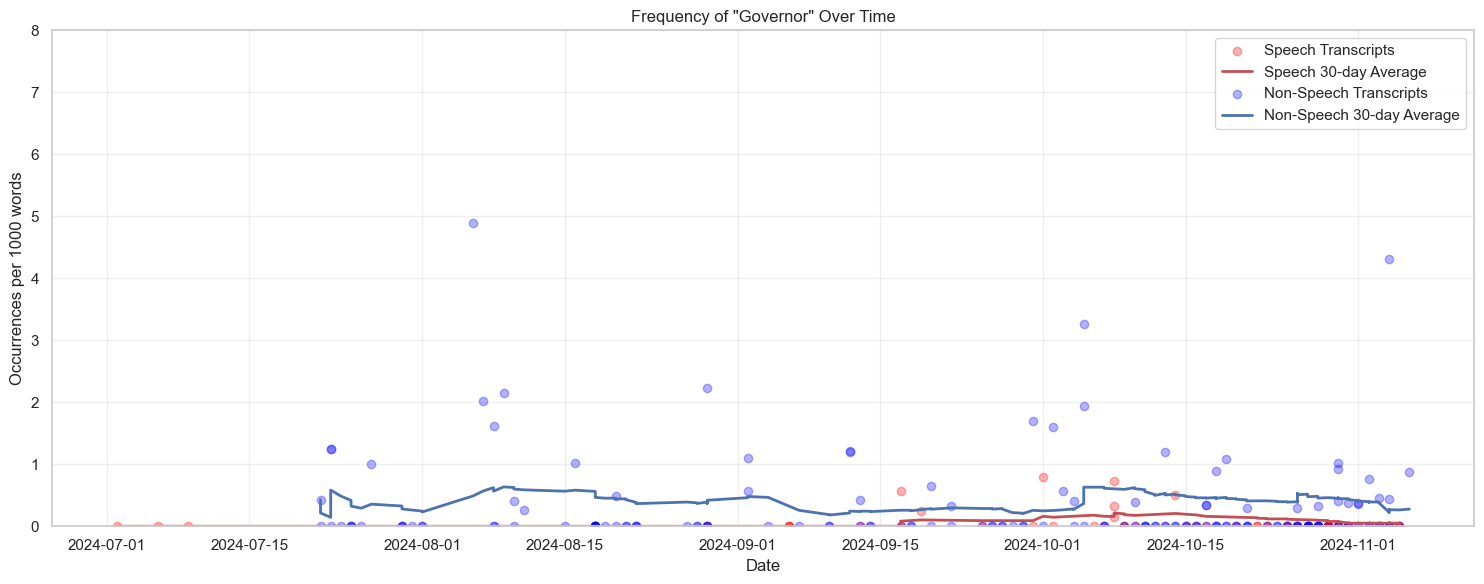

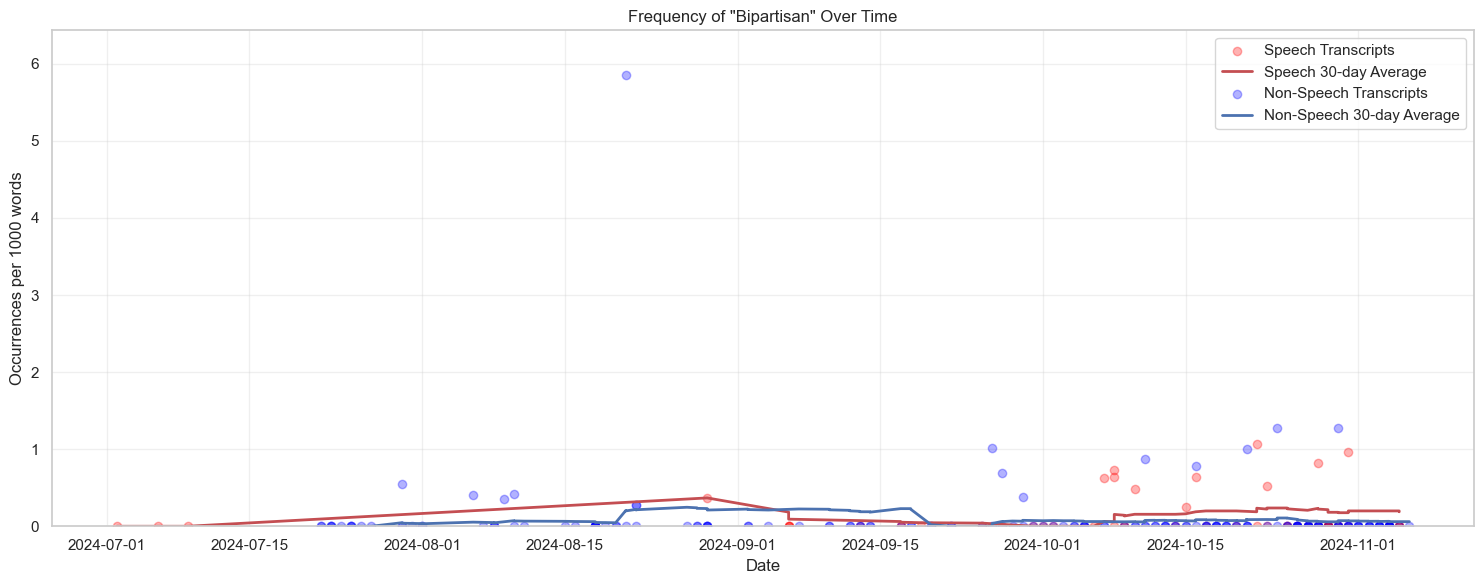

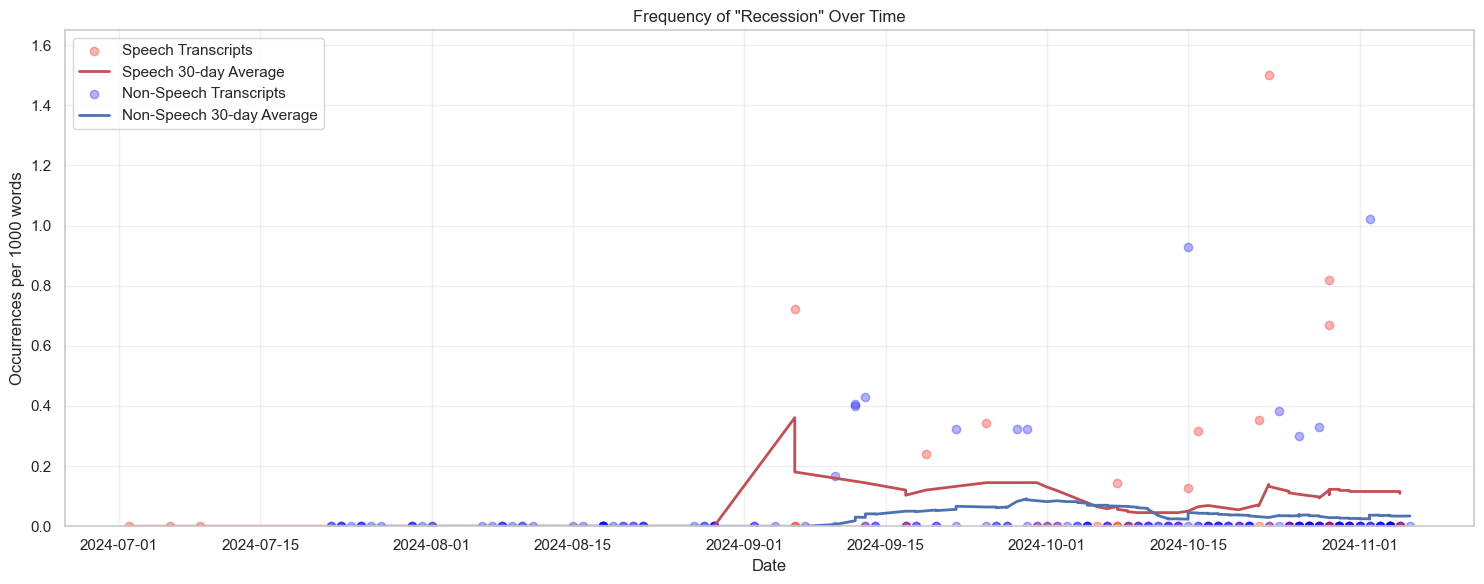

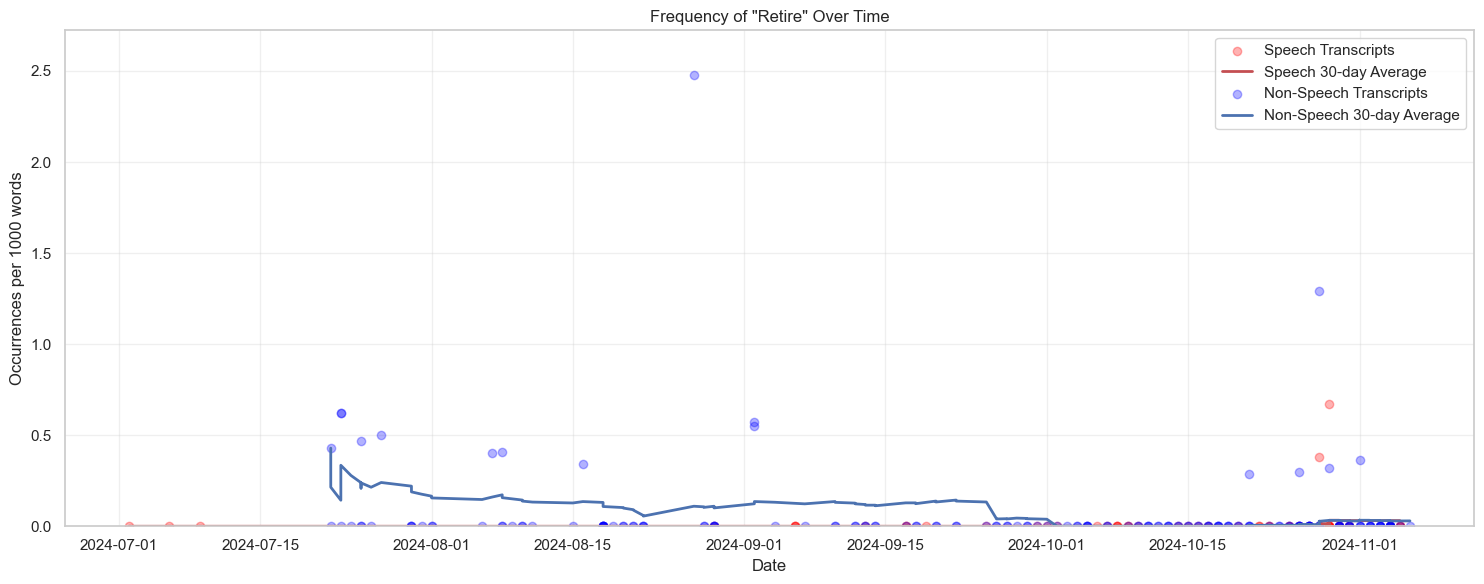

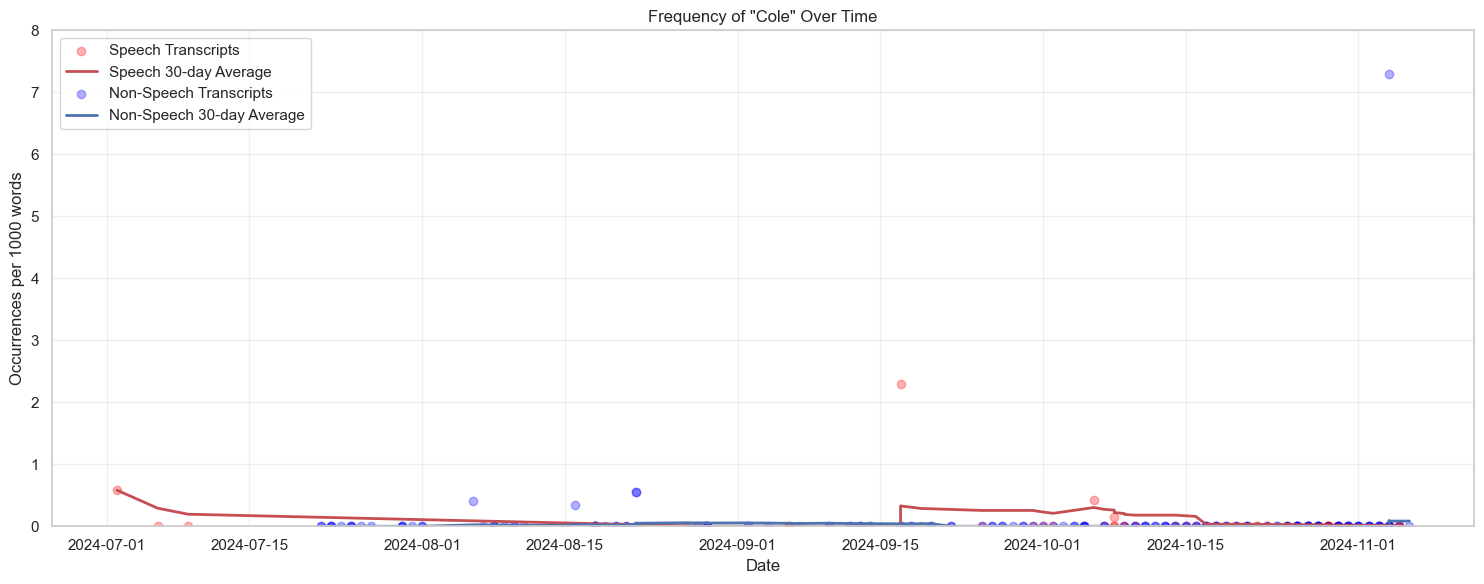

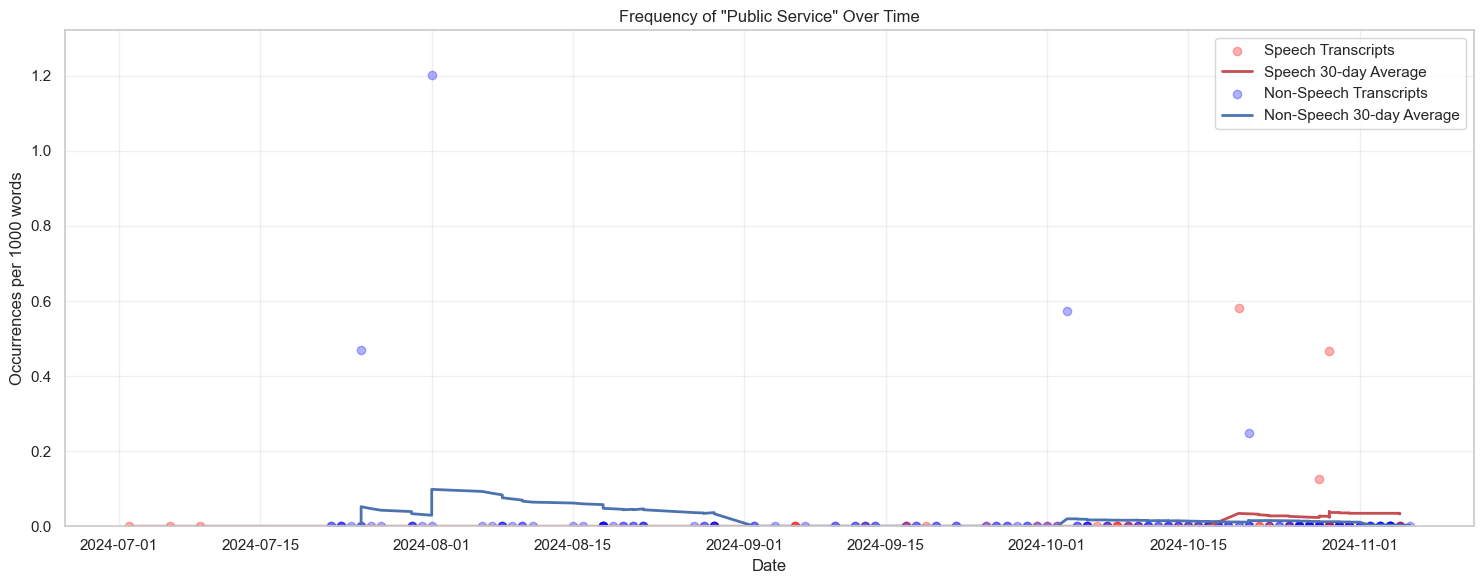

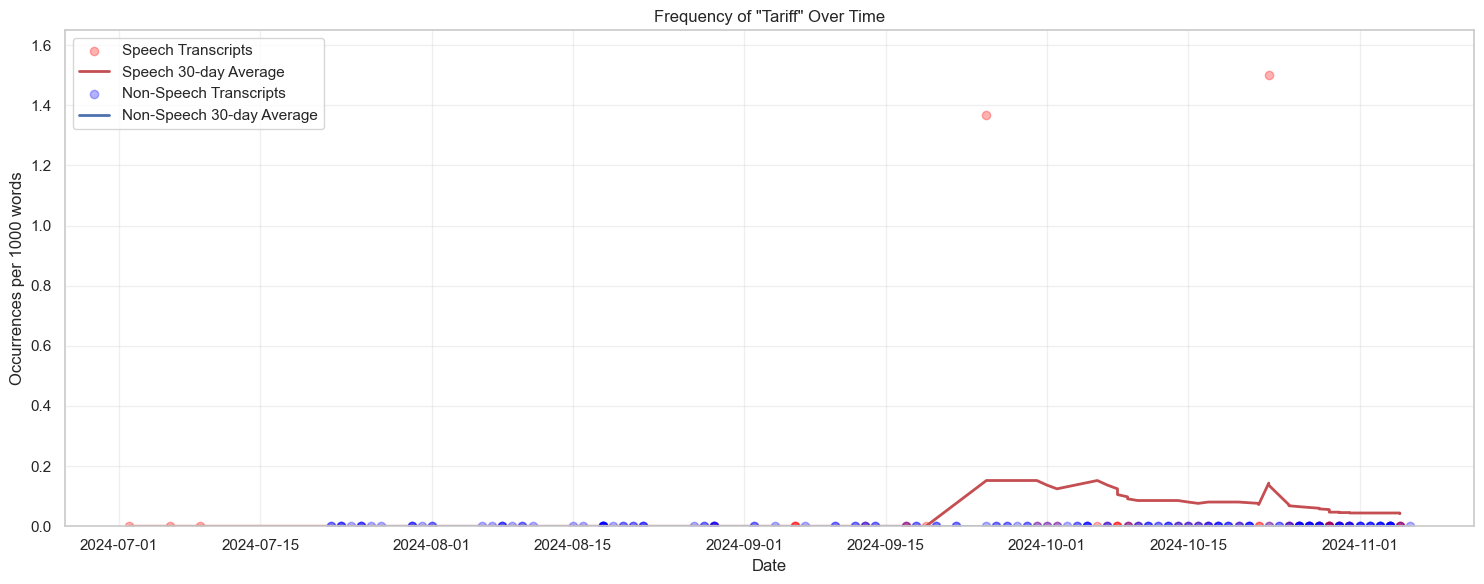

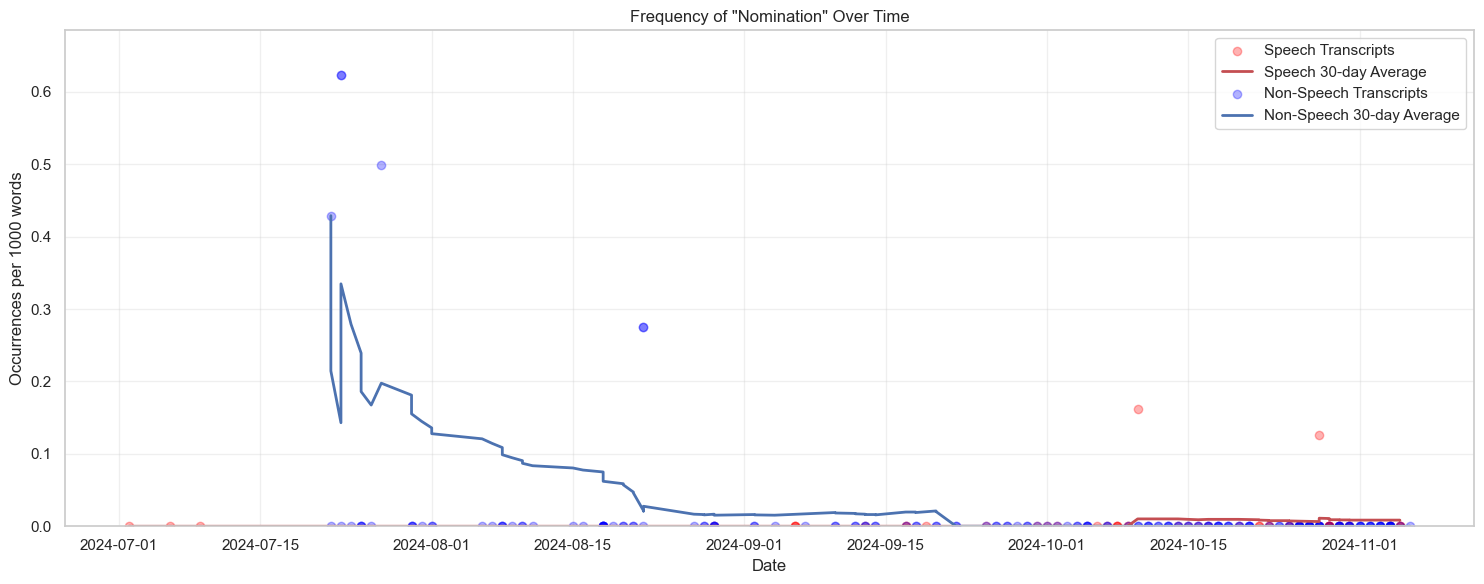

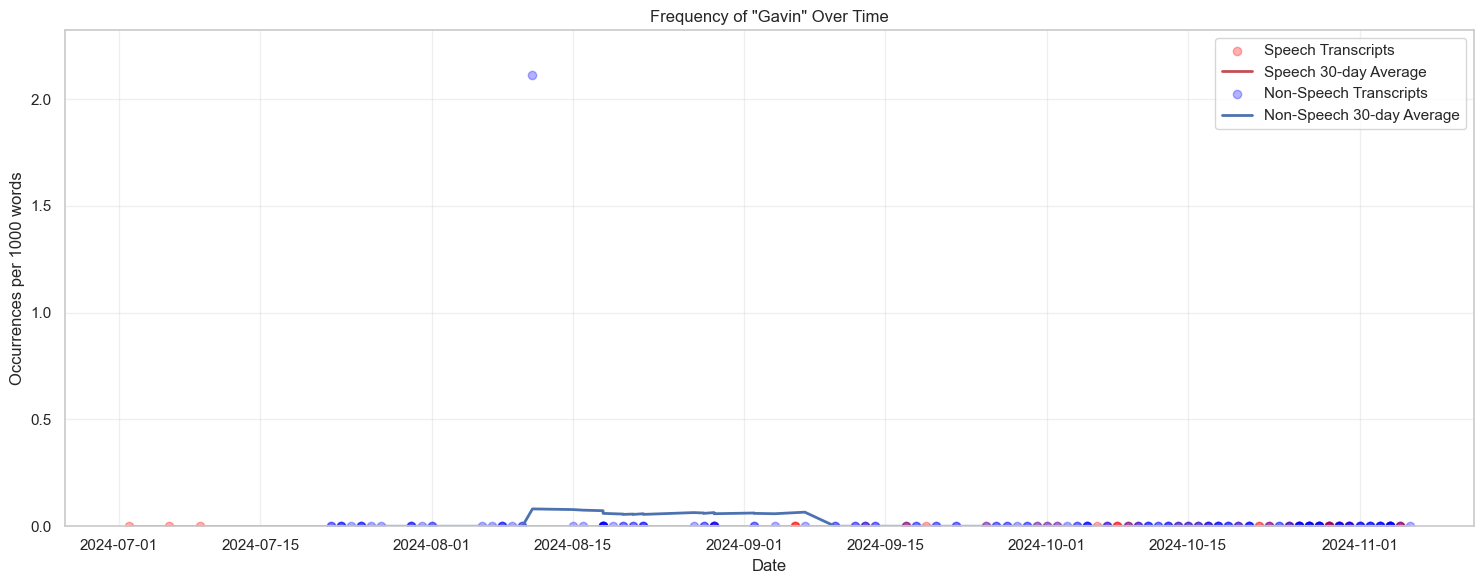

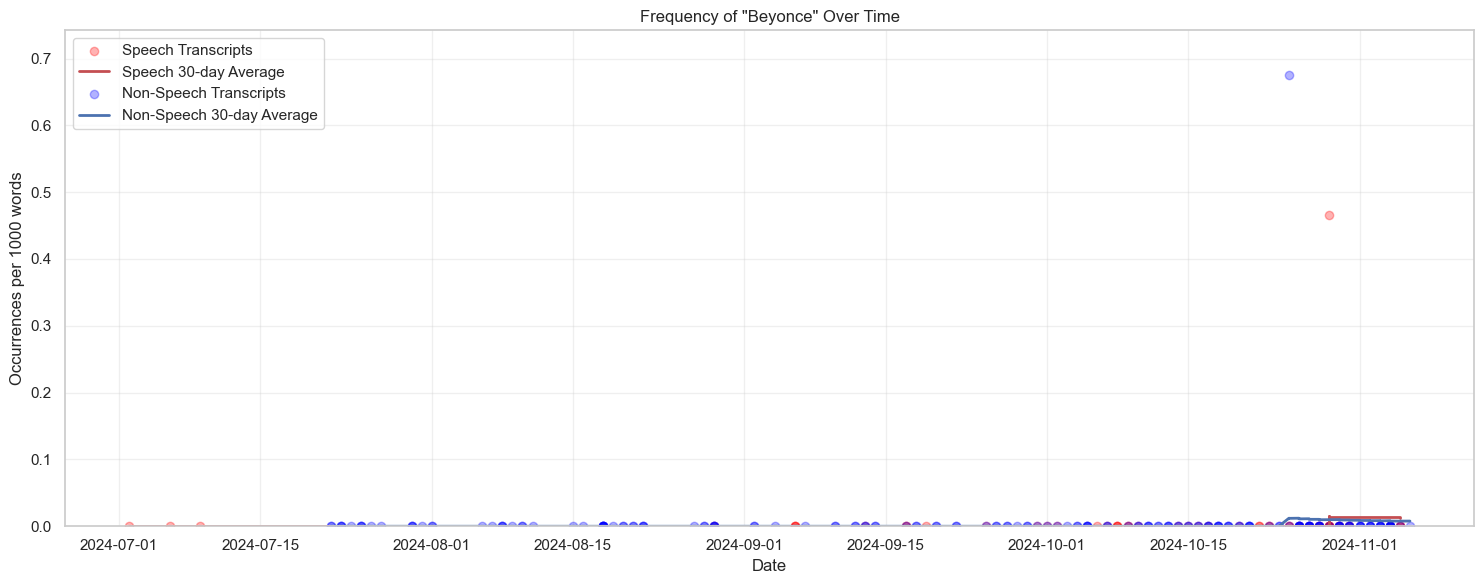

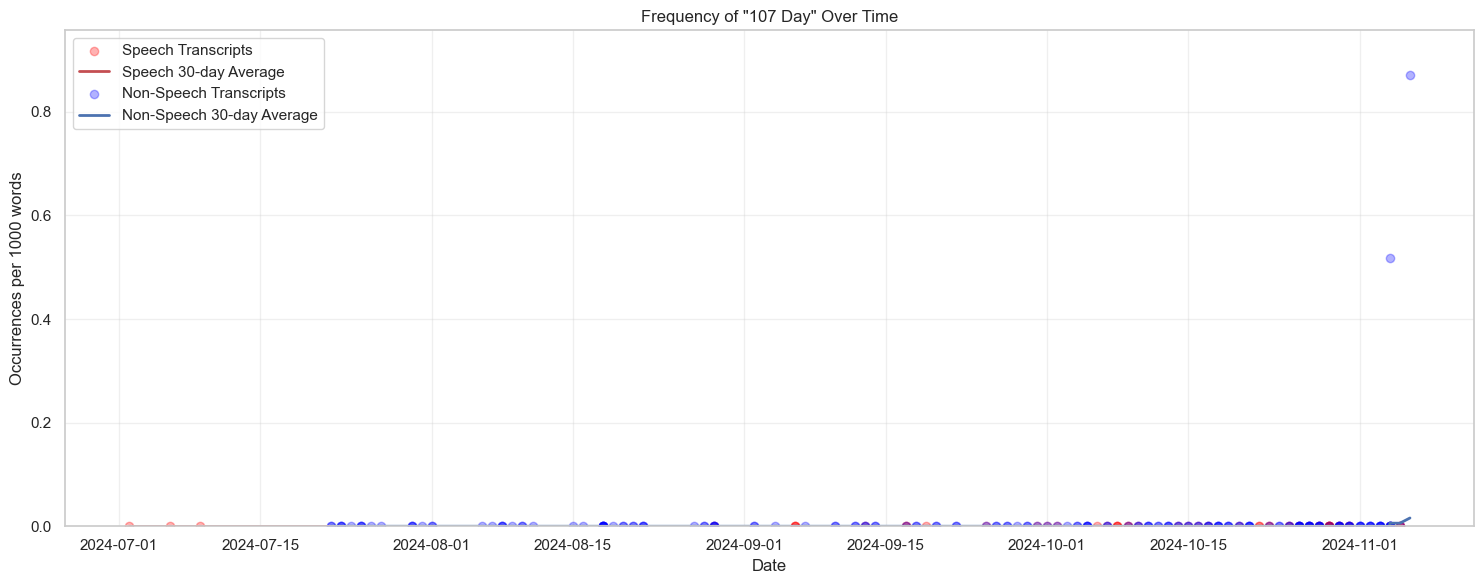

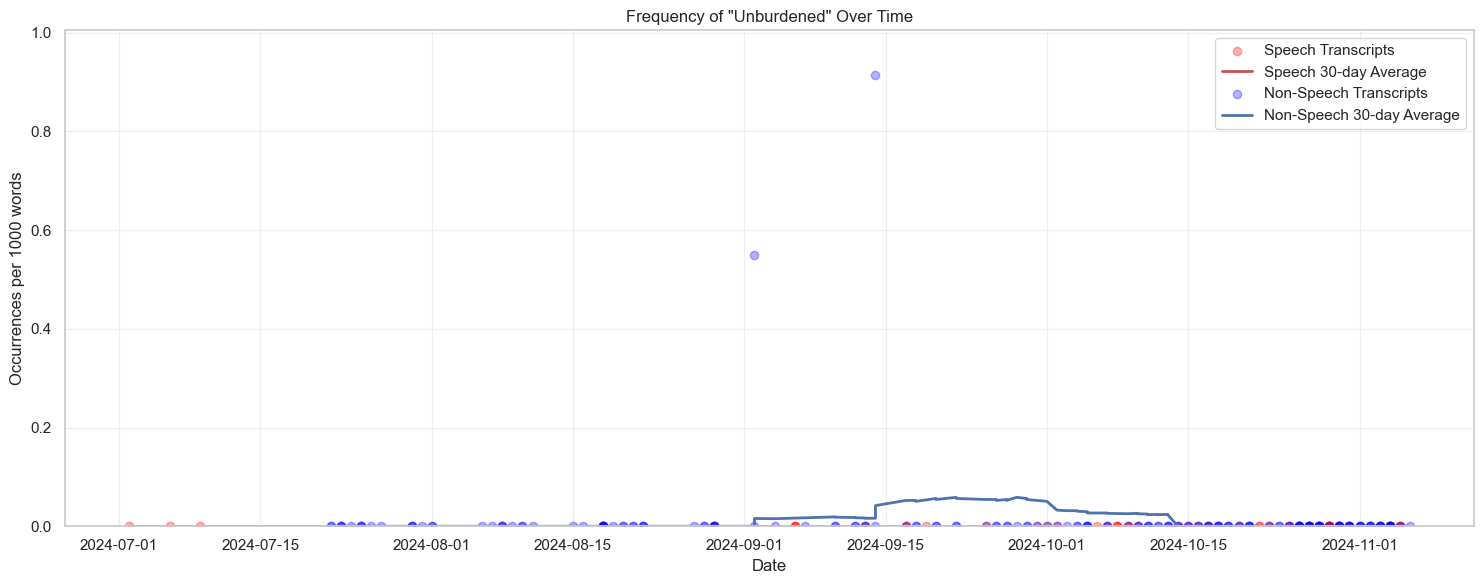

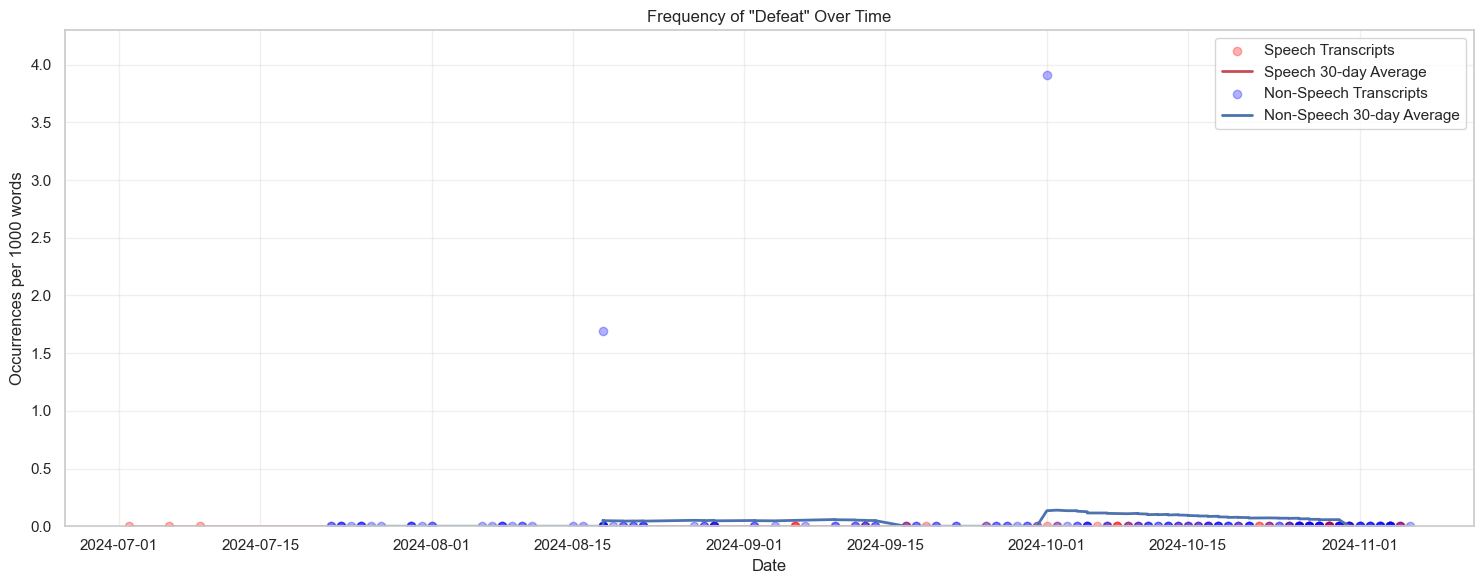

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


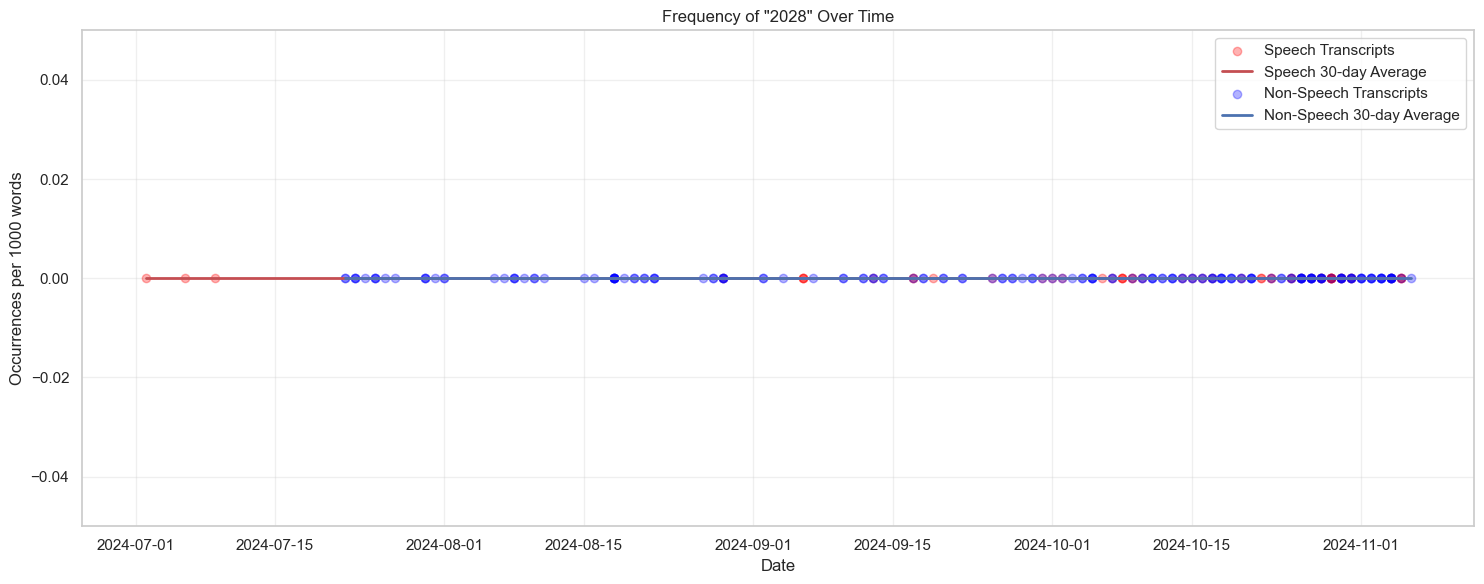

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


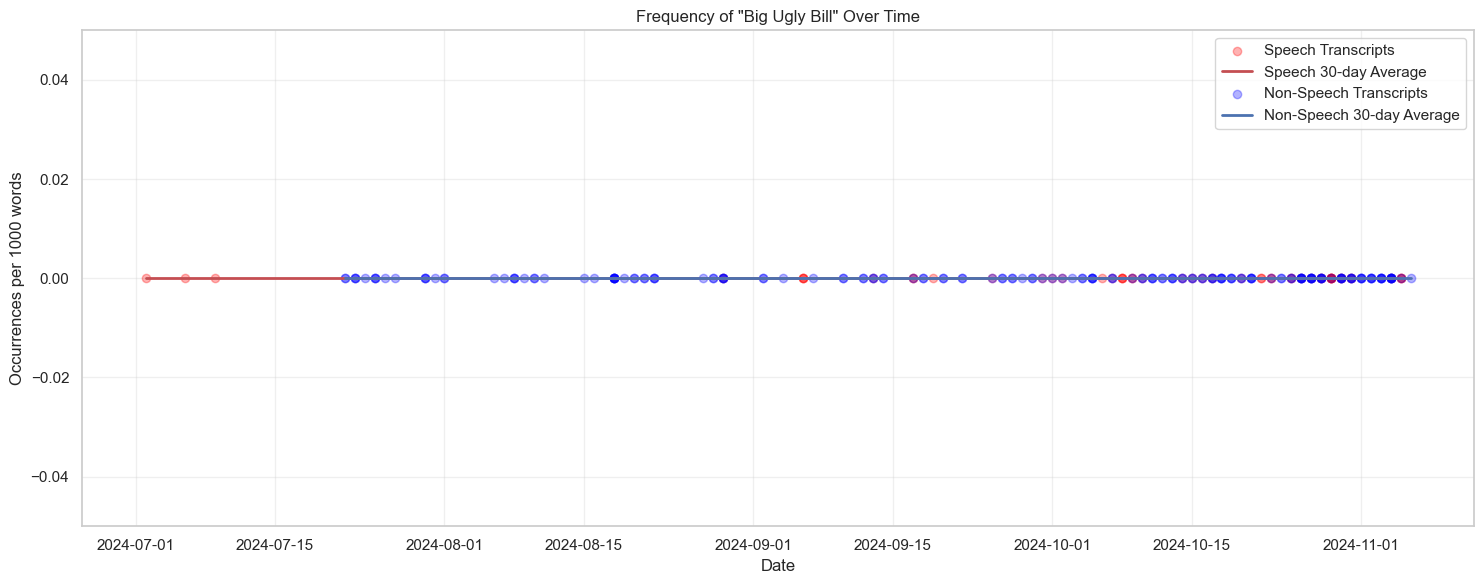

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


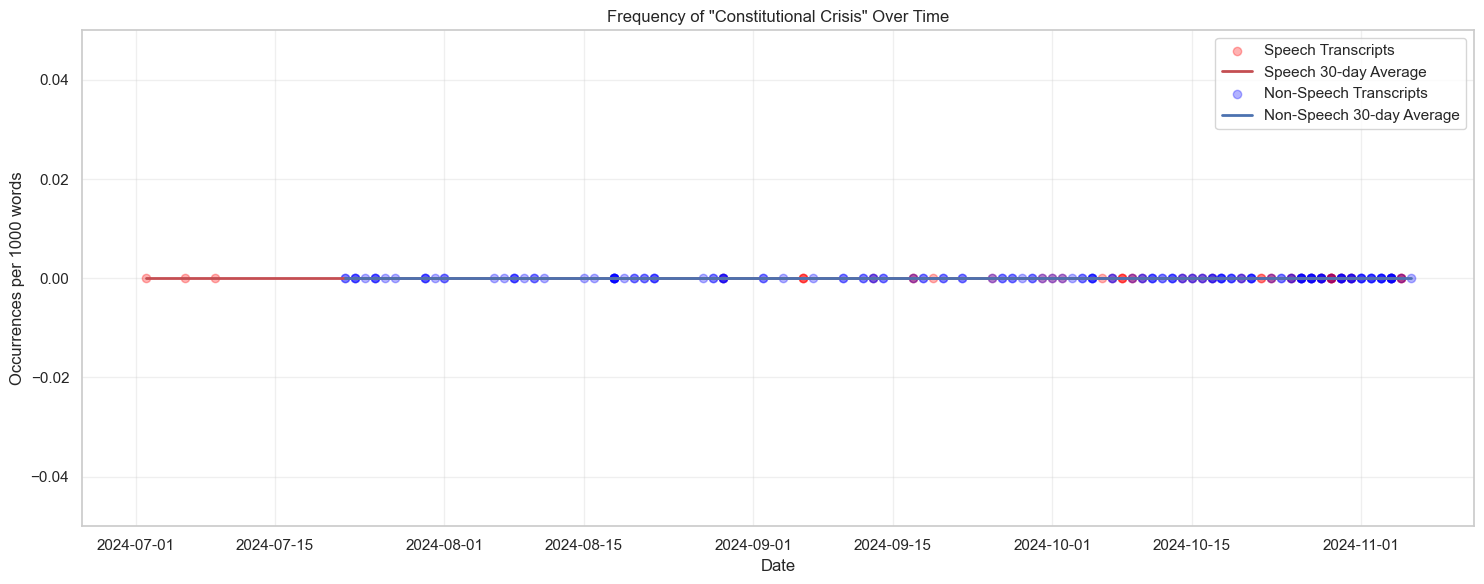

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


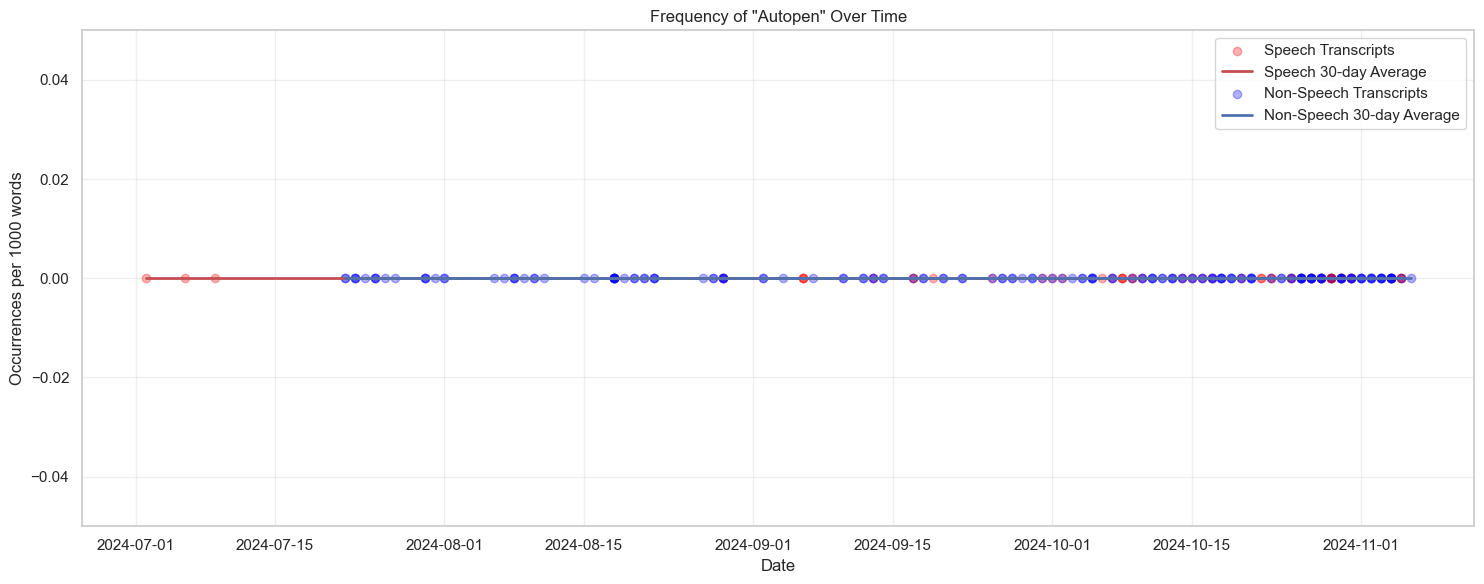

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


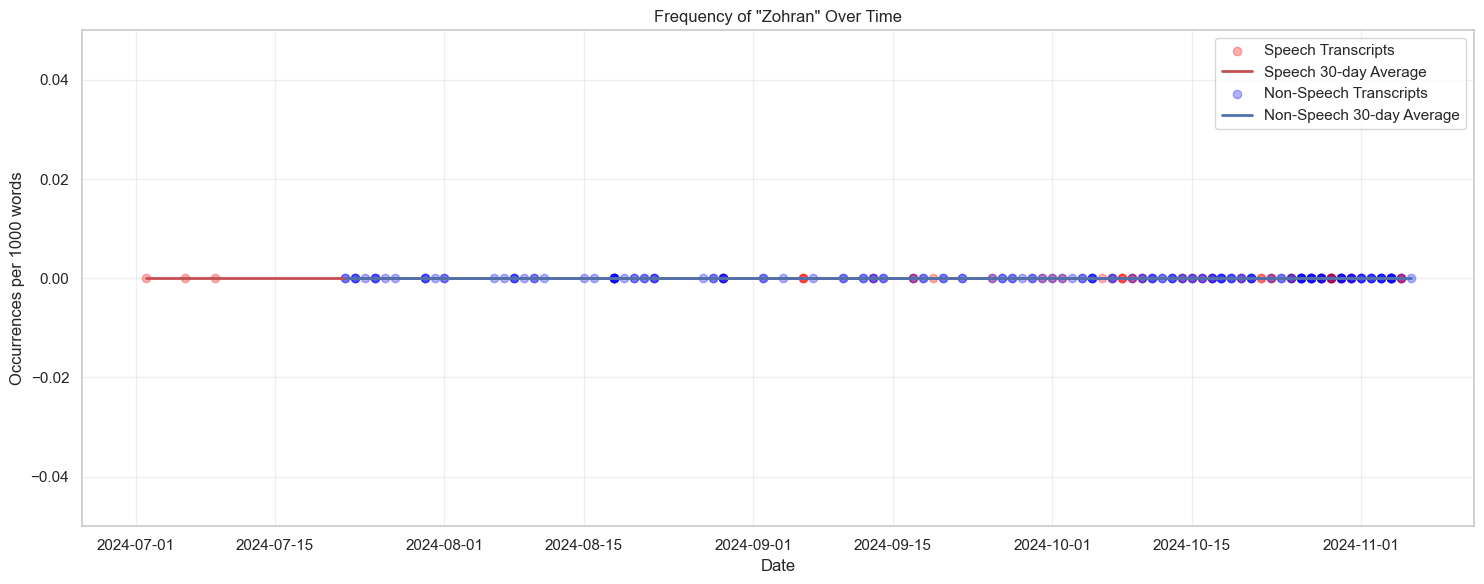

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


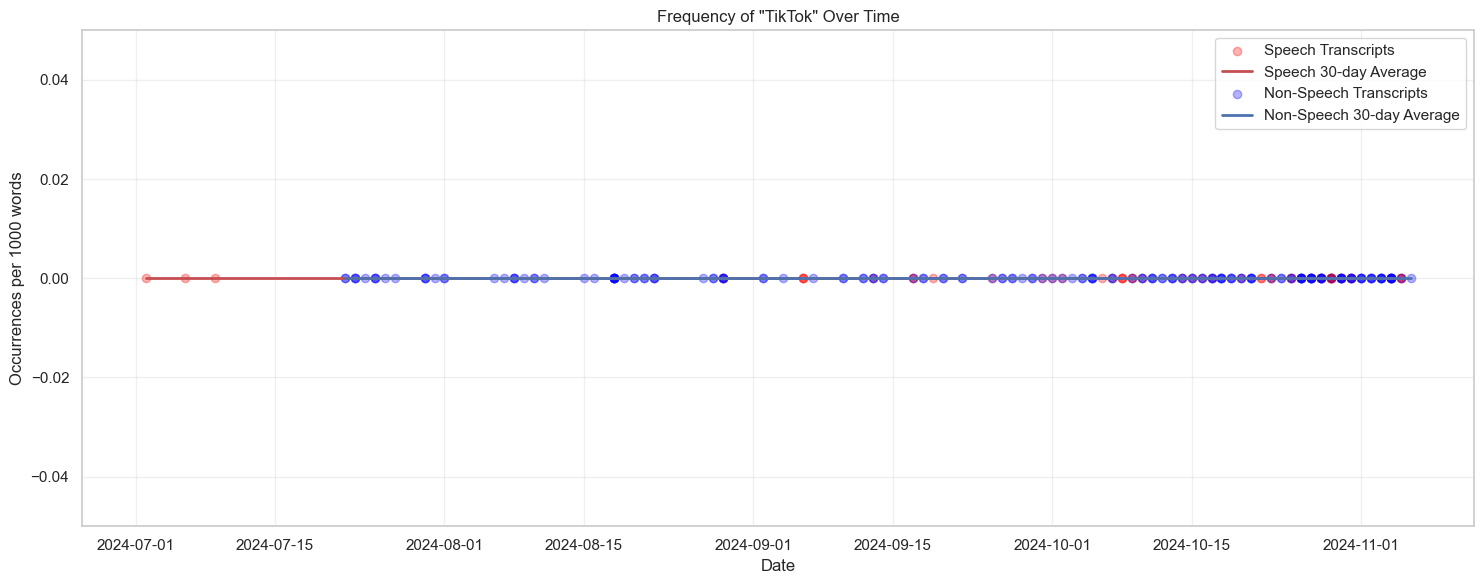

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


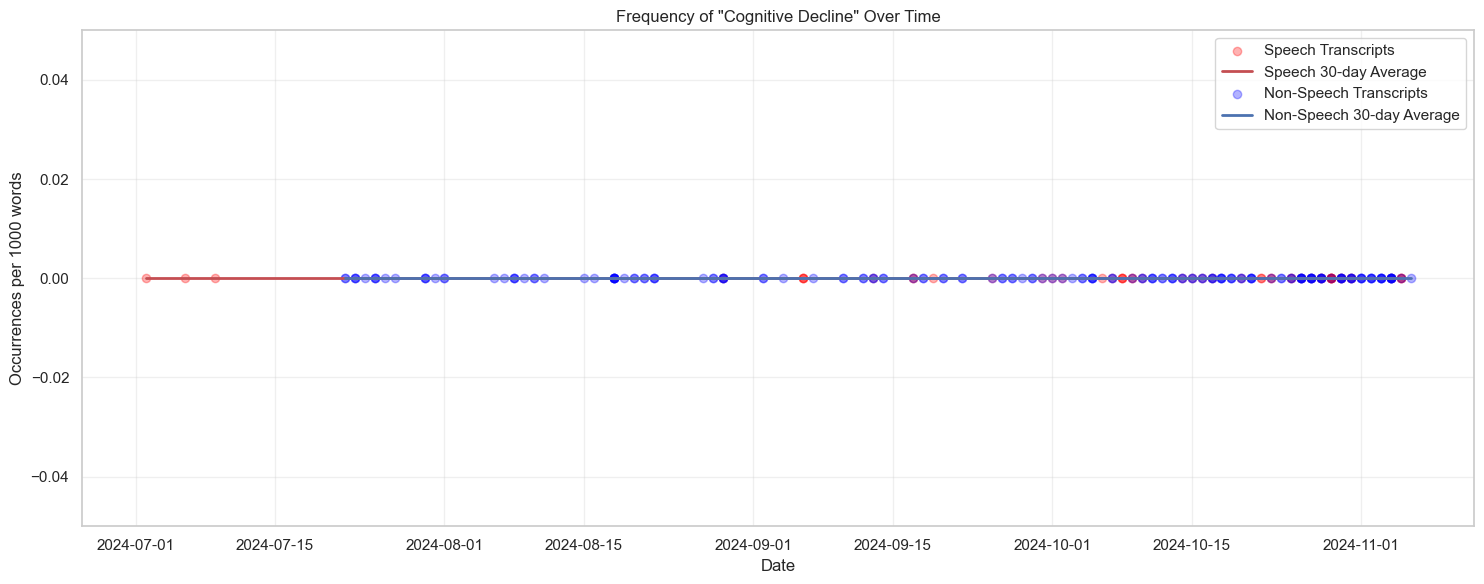

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


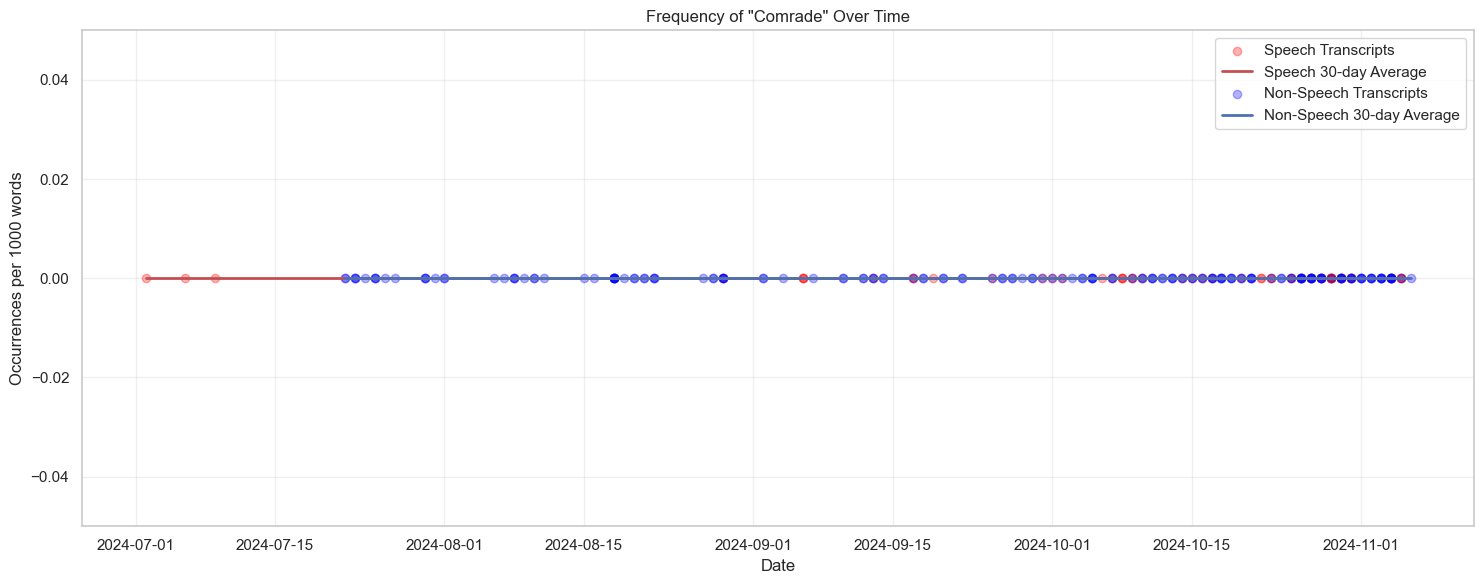

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


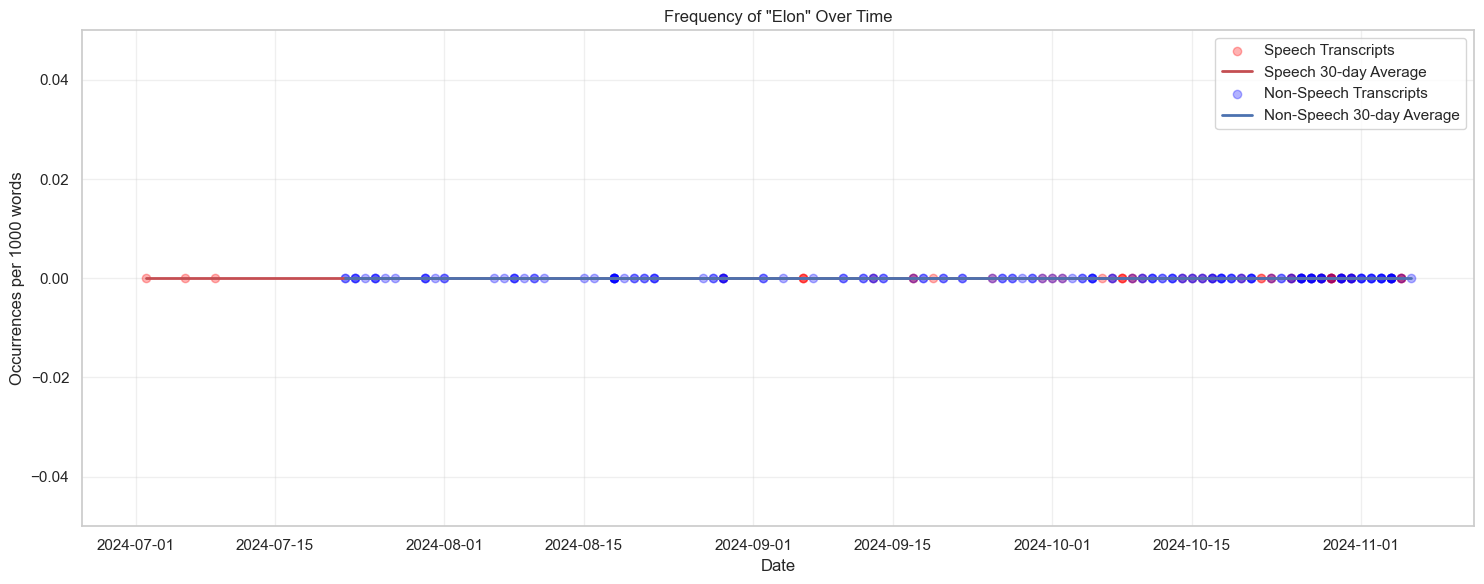

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


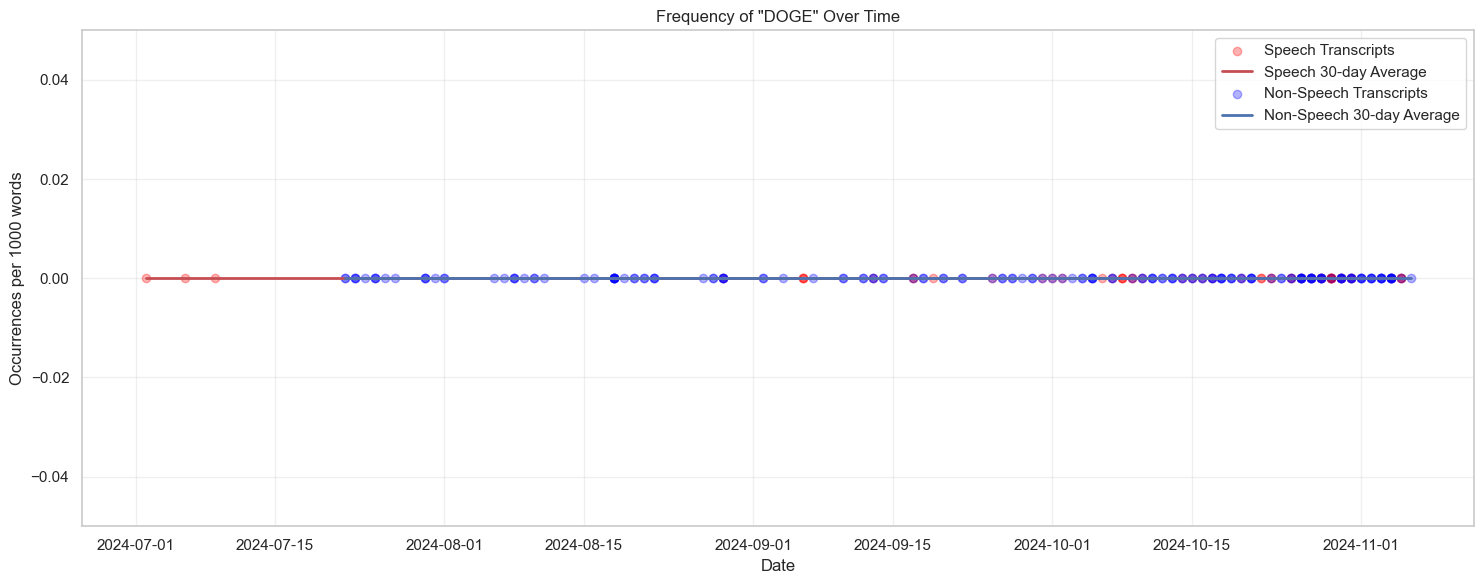

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_7148/595956357.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


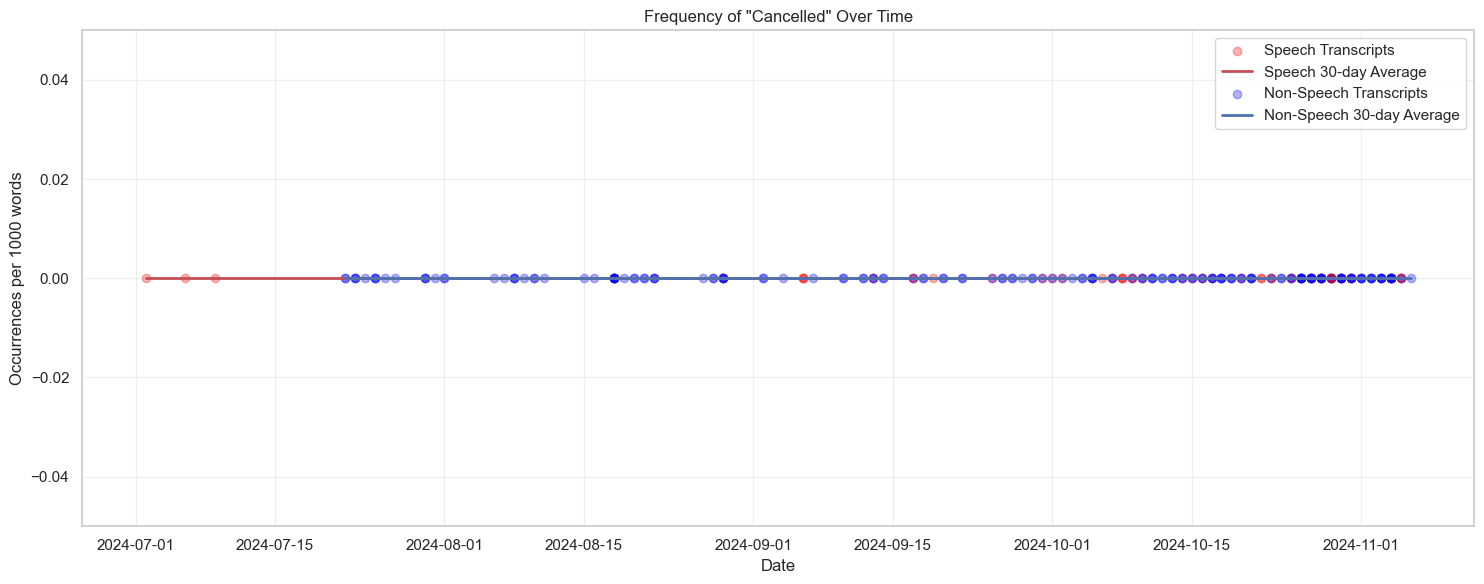

In [50]:
def plot_phrase_frequency_over_time(df_speech, df_non_speech, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for speech and non-speech"""
    plt.figure(figsize=(15, 6))
    
    # Process speech data
    df_speech = df_speech.copy()
    df_speech[f'{phrase}_freq'] = (df_speech[phrase] / df_speech['text_length']) * 1000
    speech_series = df_speech.set_index('date')[f'{phrase}_freq']
    speech_rolling = speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-speech data
    df_non_speech = df_non_speech.copy()
    df_non_speech[f'{phrase}_freq'] = (df_non_speech[phrase] / df_non_speech['text_length']) * 1000
    non_speech_series = df_non_speech.set_index('date')[f'{phrase}_freq']
    non_speech_rolling = non_speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot speech data
    plt.scatter(speech_series.index, speech_series.values, alpha=0.3, color='red', label='Speech Transcripts')
    plt.plot(speech_rolling.index, speech_rolling.values, 'r-', linewidth=2, label=f'Speech {window}-day Average')
    
    # Plot non-speech data
    plt.scatter(non_speech_series.index, non_speech_series.values, alpha=0.3, color='blue', label='Non-Speech Transcripts')
    plt.plot(non_speech_rolling.index, non_speech_rolling.values, 'b-', linewidth=2, label=f'Non-Speech {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_speech[f'{phrase}_freq'].max(),
        df_non_speech[f'{phrase}_freq'].max()
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    interview_freq = (df_interview[phrase].sum() / df_interview['text_length'].sum()) * 1000
    non_interview_freq = (df_non_interview[phrase].sum() / df_non_interview['text_length'].sum()) * 1000
    phrase_freqs[phrase] = (interview_freq + non_interview_freq) / 2

# Sort phrases by frequency and plot
for phrase in sorted(phrase_freqs, key=phrase_freqs.get, reverse=True):
    plot_phrase_frequency_over_time(df_interview, df_non_interview, phrase)

## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [63]:
colbert_word_count = df_interview[df_interview['file'] == '2024-10-08_stephen_colbert_interviews_kamala_harris_on_cbs_the_late_show.txt']['text_length'].mean()

In [ ]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1)
        })
    
    return pd.DataFrame(predictions)

length = colbert_word_count
print(f"Using length: {length} words")

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_interviews = calculate_poisson_predictions(df_interview, length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on interviews:")
display(format_prediction_table(predictions_interviews, 'interviews'))

Using length: 3111.0 words
Predictions based on all appearances:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
2,Donald,17.40,100.0%,5.59,2164
1,Campaign,1.89,85.0%,0.61,235
7,Debate,1.08,66.0%,0.35,134
27,Biden,0.90,59.0%,0.29,112
3,Governor,0.84,57.0%,0.27,104
10,Bipartisan,0.35,29.0%,0.11,43
8,Recession,0.18,16.0%,0.06,22
9,Retire,0.17,16.0%,0.05,21
22,Cole,0.13,12.0%,0.04,16
4,Public Service,0.06,6.0%,0.02,8



Predictions based on interviews:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
2,Donald,13.35,100.0%,4.29,545
7,Debate,0.81,55.0%,0.26,33
27,Biden,0.76,53.0%,0.24,31
10,Bipartisan,0.54,42.0%,0.17,22
1,Campaign,0.37,31.0%,0.12,15
8,Recession,0.24,22.0%,0.08,10
3,Governor,0.22,20.0%,0.07,9
22,Cole,0.20,18.0%,0.06,8
25,Tariff,0.12,12.0%,0.04,5
9,Retire,0.10,9.0%,0.03,4


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [68]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

# Calculate predictions using both models
avg_speech_length = df['text_length'].mean()

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on interviews:")
nb_predictions_interviews = calculate_negative_binomial_predictions(df_interview, avg_speech_length)
display(format_prediction_table(nb_predictions_interviews))

Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
2,Donald,9.49,0.85,114.97,88.1%
1,Campaign,1.03,0.10,13.10,21.5%
7,Debate,0.59,0.10,46.84,17.5%
27,Biden,0.49,0.10,3.12,16.3%
3,Governor,0.46,0.10,2.78,15.8%
10,Bipartisan,0.19,0.10,0.58,10.1%
8,Recession,0.10,100.00,0.09,9.2%
9,Retire,0.09,0.19,0.14,7.2%
22,Cole,0.07,0.10,0.75,5.2%
4,Public Service,0.04,100.00,0.03,3.4%


Negative Binomial Predictions based on interviews:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
2,Donald,7.28,0.82,72.36,84.6%
7,Debate,0.44,0.71,0.71,29.0%
27,Biden,0.41,0.42,0.82,25.0%
10,Bipartisan,0.29,100.00,0.24,25.4%
1,Campaign,0.20,100.00,0.08,18.1%
8,Recession,0.13,0.22,0.22,9.9%
3,Governor,0.12,100.00,0.10,11.3%
22,Cole,0.11,0.10,0.32,7.0%
25,Tariff,0.07,0.10,0.22,5.0%
9,Retire,0.05,100.00,0.03,5.2%


In [ ]:
avg_speech_length



np.float64(11445.655367231639)

In [ ]:
avg_speech_length

np.float64(11445.655367231639)

## Recent Usage in context

In [ ]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df_speech, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Kennedy' ===

Date: 2025-07-03 (speech)
Context: ...letes from all 50 states. It's gonna be great. And this phenomenal patriot exporting event will be nationally televised and it'll be led by our great Secretary of Health and Human Services, Robert F. Kennedy, Jr., who's really  -- he's great.

And he's, uh, he's a little different, right? He's a little -- We needed somebody different. You know, autism, you go back, I guess 18 years, 10,000, think of this...

Date: 2025-05-19 (speech)
Context: ...thing else. So, we're here for a different reason tonight. We're going to have to fix this one too. We're fixing everything. We're going around Mr. Fixit, Mrs. Fixit. Anybody want to join me? But the Kennedy Center, when I said I'll do this, I hadn't been there.

That's the last time I'll take a job without looking at it  and -- but it's got a tremendous amount. Lindsey Graham and some people put in the ...

Date: 2025-05-19 (speech)
Context: ... board.

You have a lot of

## Per-Speech Frequencies


/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_5752/1107231187.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


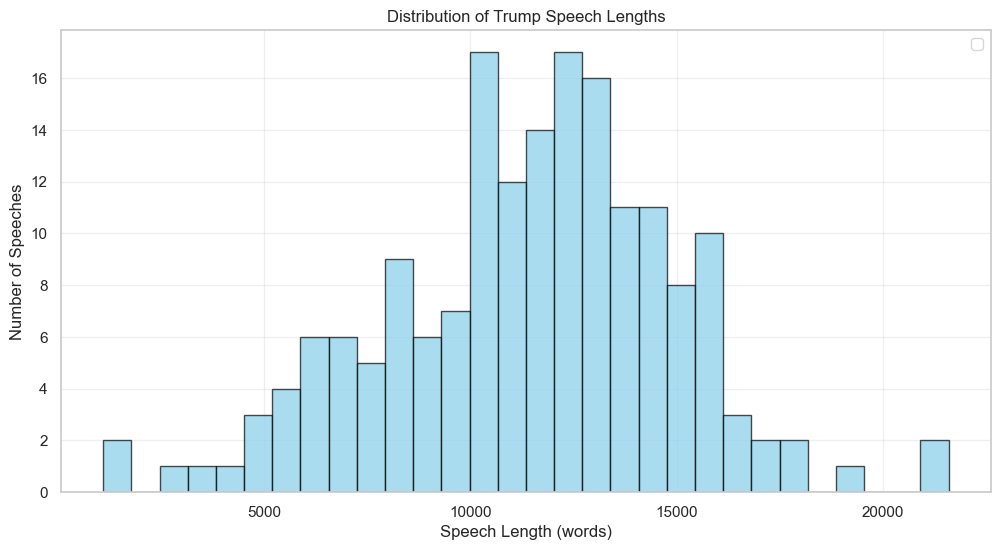

In [ ]:

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Find and display the 5 shortest speeches with their full text
shortest_speeches = df_speech.nsmallest(5, 'text_length')

print("5 Shortest Speeches:")
for _, speech in shortest_speeches.iterrows():
    print("=" * 80)
    print(f"File: {speech['file']}")
    print(f"Date: {speech['date'].strftime('%Y-%m-%d')}")
    print(f"Category: {speech['category']}")
    print(f"Length: {speech['text_length']:,} words")
    print("-" * 40)
    print(speech['text'])
    print()




5 Shortest Speeches:
File: 2024-07-13_donald_trump_holds_a_political_rally_in_butler_pennsylvania.txt
Date: 2024-07-13
Category: speech
Length: 1,093 words
----------------------------------------
This is a big crowd. This is a big, big, beautiful crowd. I wish the fake news back there would, uh, show it. I wish they'd spin their cameras and show it because nobody would believe it. You know, the other day, Biden was saying, "I get big crowds," meaning him, he gets big crowds.

He doesn't know what a big... And there were like 93 people there. 93, you know what that is? That's where the front row Joes sit right here, 93. We got more than 93 front row Joes. Hello, Butler. Hello to Pennsylvania. I'm thrilled to be back in this beautiful Commonwealth with thousands of proud, hard-working Patriots, and that's what you are.

And we got to bring our country back to health, because our country is going to hell, if you haven't noticed. Millions and millions of people are pouring in from prisons

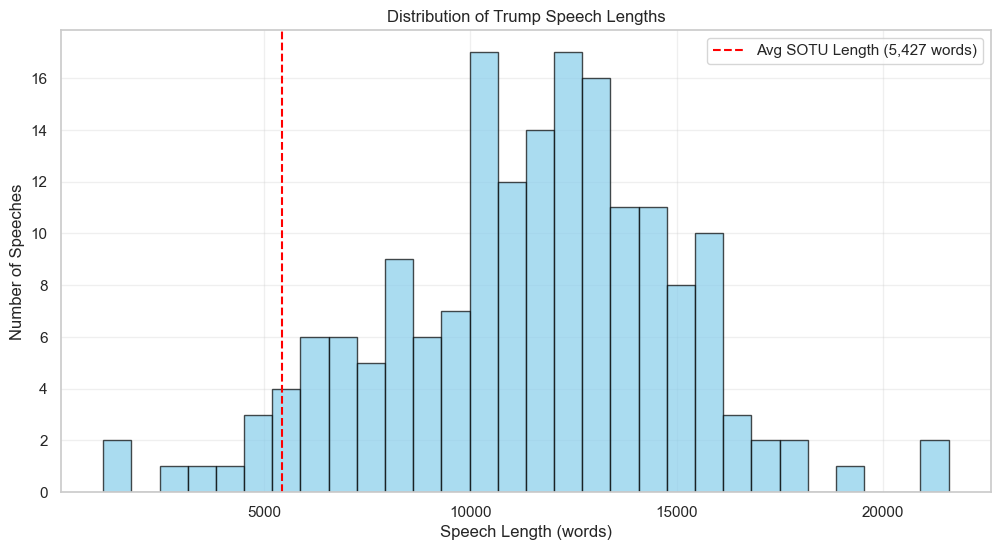

In [ ]:
sotu_mean_length = df_sotu['text_length'].mean()

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=sotu_mean_length, color='red', linestyle='--', label=f'Avg SOTU Length ({int(sotu_mean_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [66]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}
for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    speech_pct = (df_speech[phrase] >= 1).mean() * 100
    post_pct = (df_post[phrase] >= 1).mean() * 100
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        'Speeches Only': speech_pct, 
        'Post-Inauguration': post_pct
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    'Speeches Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


KeyError: '107 Day'

In [ ]:
def create_frequency_comparison(df, df_speech, df_post):
    """Create a comparison table of per-speech frequencies across datasets"""
    results = []
    
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'All Data P(≥1)': (df[phrase] >= 1).mean(),
            'All Speeches P(≥1)': (df_speech[phrase] >= 1).mean(),
            'Post-Inauguration P(≥1)': (df_post[phrase] >= 1).mean(),
            'All Data n': len(df),
            'All Speeches n': len(df_speech),
            'Post-Inauguration n': len(df_post)
        }
        results.append(result)
    
    comparison_df = pd.DataFrame(results)
    
    # Format percentages
    for col in ['All Data P(≥1)', 'All Speeches P(≥1)', 'Post-Inauguration P(≥1)']:
        comparison_df[col] = comparison_df[col].map('{:.1%}'.format)
    
    # Sort by All Data frequency
    comparison_df = comparison_df.sort_values('All Data P(≥1)', ascending=False)
    
    return comparison_df

print("Comparison of Per-Speech Frequencies (P(≥1)):")
comparison_table = create_frequency_comparison(df, df_speech, df_post)
display(comparison_table)

# ... existing code ...

Comparison of Per-Speech Frequencies (P(≥1)):


,Phrase,All Data P(≥1),All Speeches P(≥1),Post-Inauguration P(≥1),All Data n,All Speeches n,Post-Inauguration n
27,Hate Our Country,9.9%,25.4%,4.0%,554,177,278
4,Beautiful,68.6%,99.4%,68.3%,554,177,278
5,Pharmaceutical,6.7%,5.6%,11.5%,554,177,278
20,Too Late,6.0%,11.3%,5.0%,554,177,278
10,China,59.9%,95.5%,52.5%,554,177,278
17,Inflation,53.1%,93.2%,34.9%,554,177,278
9,Tariff,51.6%,80.2%,52.5%,554,177,278
7,Smart,51.4%,87.6%,40.6%,554,177,278
8,Energy,47.5%,90.4%,32.7%,554,177,278
19,Trade,43.5%,68.4%,41.4%,554,177,278


## Individual Phrase Analysis

In [ ]:
# Find speeches shorter than 6000 words with 4+ mentions of MAGA
short_maga_speeches = df[
    (df['text_length'] < 10200) & 
    (df['MAGA'] >= 4)
][['file', 'MAGA']]

print(f"\nSpeeches under 10200 words with 4+ mentions of MAGA:")
print(short_maga_speeches.sort_values('MAGA', ascending=False))

KeyError: 'MAGA'

In [ ]:
df[df['January 6'] > 0][['file', 'text_length', 'January 6', 'category']]

KeyError: 'January 6'

In [ ]:
df[df['LA'] > 0][['file', 'text_length', 'LA', 'category']].sort_values('file')

,file,text_length,LA,category
203,2023-09-29_donald_trump_addresses_a_california_gop_lunch_event_in_anaheim.txt,15552,4,speech
233,2023-10-01_donald_trump_holds_a_campaign_event_in_ottumwa_iowa.txt,13209,1,speech
96,2023-10-07_donald_trump_holds_a_campaign_rally_in_waterloo_iowa.txt,10179,1,speech
136,2023-10-11_donald_trump_addresses_his_club_47_fan_club_in_west_palm_beach_florida.txt,17529,1,speech
190,2023-12-17_donald_trump_holds_a_political_rally_in_reno_nevada.txt,10979,1,speech
114,2024-01-05_donald_trump_holds_a_campaign_rally_in_sioux_center_iowa.txt,19189,2,speech
146,2024-01-06_donald_trump_holds_a_campaign_event_in_clinton_iowa.txt,11001,1,speech
97,2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt,15275,1,speech
232,2024-01-21_donald_trump_holds_a_political_rally_in_rochester_new_hampshire.txt,13102,2,speech
94,2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt,11312,1,speech


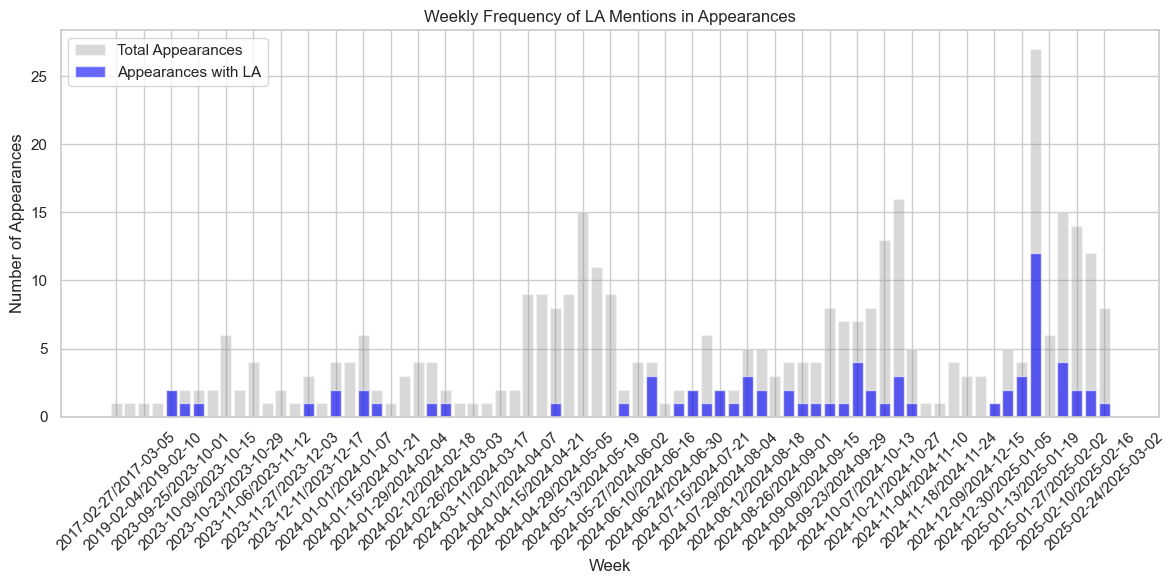

In [ ]:
# Convert date strings to datetime 
df['date'] = pd.to_datetime(df['date'])

# Create weekly bins
df['week'] = df['date'].dt.to_period('W')

# Group by week and calculate metrics
weekly_stats = df.groupby('week').agg({
    'file': 'count',  # Total speeches per week
    'LA': lambda x: (x > 0).sum()  # Speeches containing LA per week
}).reset_index()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for speech counts
ax.bar(range(len(weekly_stats)), weekly_stats['file'], alpha=0.3, color='gray', label='Total Appearances')
ax.bar(range(len(weekly_stats)), weekly_stats['LA'], alpha=0.6, color='blue', label='Appearances with LA')

# Customize axes
ax.set_xlabel('Week')
ax.set_ylabel('Number of Appearances')

# Set x-axis ticks to show dates every 2 weeks
tick_indices = range(0, len(weekly_stats), 2)
plt.xticks(tick_indices, [str(weekly_stats['week'].iloc[i]) for i in tick_indices], rotation=45)

# Add legend
ax.legend(loc='upper left')

plt.title('Weekly Frequency of LA Mentions in Appearances')
plt.tight_layout()
plt.show()
